In [1]:
%pylab inline
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 256

# Data

In [3]:
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

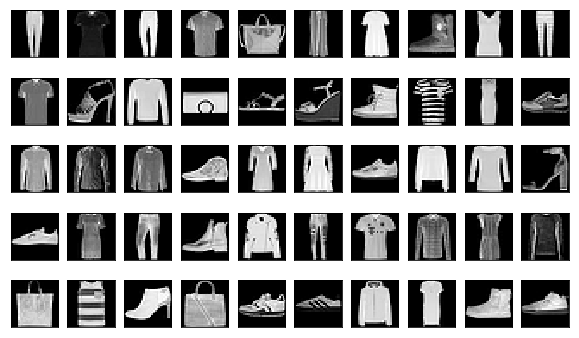

In [4]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [15]:
class Discriminator(nn.Module):
    def __init__(self, channel:int=256):
        super(Discriminator, self).__init__()
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//4, kernel_size=6, stride=1, padding=2)
        self.conv2 = nn.Conv2d(channel//4, channel//3, kernel_size=5, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//3)
        self.conv3 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel//2)
        self.conv4 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv5 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x):
        h1: Variable = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2: Variable = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3: Variable = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4: Variable = F.leaky_relu(self.bn4(self.conv4(h3)), negative_slope=0.2)
        
        # Global Average Pooling
        h5 = F.leaky_relu(self.conv5(h4), negative_slope=0.2)
        gap = F.avg_pool2d(h5, kernel_size=h5.size()[2:]).view(h5.size()[0], -1)
        output = F.sigmoid(gap)
        return output
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

Discriminator(
  (conv1): Conv2d (1, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d (64, 85, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (85, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d (256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [34]:
class Generator(nn.Module):
    def __init__(self, channel:int=512):
        super(Generator, self).__init__()
        
        nn.ConvTranspose2d()
            
        self.conv1 = nn.Conv2d(1, channel//6, kernel_size=5,stride=1, padding=2)
        self.conv2 = nn.Conv2d(channel//6, channel//5, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(channel//5)
        self.conv3 = nn.Conv2d(channel//5, channel//4, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(channel//4)
        self.conv4 = nn.Conv2d(channel//4, channel//3, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(channel)
        self.conv5 = nn.Conv2d(channel//3, channel//2, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(channel//2)
        self.conv6 = nn.Conv2d(channel//2, channel, kernel_size=5, stride=2, padding=4)
        self.bn6 = nn.BatchNorm2d(channel)
        

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator(
  (conv1): Conv2d (1, 85, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d (85, 102, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn2): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (102, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 170, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d (170, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv6): Conv2d (256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
)


# Train

In [6]:
N_EPOCH = 100

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [13]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)   
        d_real_loss = loss_f(y_real_pred, real_y)
        
        raise Exception
        
        
#         d_real_loss.backward()
#         d_optimizer.step()
        
        # Calculate the loss with fake images
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions).detach()
        y_fake_pred = D(fake_images)
        d_fake_loss = loss_f(y_fake_pred, fake_y)
#         d_fake_loss.backward()
#         d_optimizer.step()
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        fake_distributions = Variable(torch.randn((BATCH_SIZE, 100)).cuda())
        fake_images = G(fake_distributions)
        y_pred = D(fake_images)
        g_loss = loss_f(y_pred, real_y)
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
    print()

Exception: 